#### Last Modified: Jan 3rd, 2022 (Opal). 

# S-OpInf on MHD (MAS Code) Solar Wind Radial Speed dataset


In [1]:
import os
curr_dir = os.getcwd()
os.chdir("../")
print("current directory path = ", os.getcwd())

current directory path =  /Users/oissan/PycharmProjects/Space-Weather-ROM


In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy.interpolate import interp1d, interp2d
from scipy.interpolate import RegularGridInterpolator
from scipy import stats
import numpy as np 

import time
import astropy.units as u

In [3]:
os.chdir(os.getcwd() + "/code/")
from numerical_methods import apply_numerical_method
from hux_propagation import apply_hux_f_model
os.chdir("../")

In [4]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

# Import MHD solar wind velocity results.

In [5]:
# mas output - br, rho, vr
cr = "2210"
mas_path = get_mas_path(cr=cr)
model = MASOutput(mas_path)
print(model.variables)

['br', 'rho', 'vr']


In [6]:
# read in MHD velocity results. 
vr_model = model['vr']

In [7]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# number of phi indexes 
n = len(p)
# delta phi
dp = p[1:] - p[:-1]
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
# 1 solar radii = 695,700 km
r = (vr_model.r_coords * u.solRad).to(u.km)
# change in r
dr = r[1:] - r[:-1]
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [8]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

In [9]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 

# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

In [10]:
V = np.array(f[:, 55, :])

In [11]:
V_HUX = apply_hux_f_model(f[:, 55, 0], (r[1:]-r[:-1]).to(u.km).value, p[1:] -p[:-1]).T

In [12]:
V_HUX.shape

(129, 140)

# Solar Wind

Due to the high temperature of the Sun's upper atmosphere, called the corona, particles are able to escape the Sun's gravity, resulting in the Solar Wind. The solar wind is a stream of charged particles mostly consists of electrons, protons and alpha particles. The solar wind varies in density, temperature and speed over time and over solar latitude and longitude.

Here we will model the radial velocity of the Solar Wind protons denoted by $v_{r}$. As the solar wind propagates out in the heliosphere it can reach velocities of around 300-700 km/sec. 

# MAS Model 
The MAS Model
The MHD equations used in MAS are \[ \begin{alignat}{2} \frac{\partial {\bf A}}{\partial t} &= {\bf v} \times {\bf B} -{\frac{c^2}{4\,\pi}\,\color{lightblue}{\eta}\,\nabla \times \nabla \times {\bf A}} \\ \frac{\partial \rho}{\partial t} &=-\nabla\cdot(\rho\,{\bf v}) \\ \frac{\partial T}{\partial t} &=-\nabla\cdot(T\,{\bf v})- (\gamma - 2)\left(T\,\nabla\cdot{\bf v}\right)+\left.\frac{(\gamma-1)}{2\,k}\frac{m_p}{\rho}\right[\left.- \nabla\cdot\left({\bf \color{lightblue}{\widetilde{\color{white}{q_1}}}} + {\bf q_2}\right) -\frac{\rho^2}{m_p^2}\,{\bf \color{lightblue}{\widetilde{\color{white}{Q}}}} + {\bf H}\right] \notag \\ \rho\,\frac{\partial{\bf v}}{\partial t}& = -\rho\,{\bf v}\cdot \nabla\,{\bf v} + \frac{1}{c}\,{\bf J} \times {\bf B} - \nabla (p+p_w) + \rho\,{\bf g} + {\bf F_{c}} + \nabla\cdot(\color{lightblue}{\nu}\,\rho\,\nabla {\bf v}) \color{lightblue}{+ \nabla\cdot\left({\bf S}\,\rho\,\nabla{\frac{\partial \bf v}{\partial t}}\right)} \notag \end{alignat} \]
where ${\bf A}$ is the magnetic vector potential, $\rho$ is the plasma density, $T$ is the temperature, ${\bf v}$ is the plasma velocity, ${\bf B}=\nabla\times {\bf A}$ is the magnetic field which satisfies the $\nabla \cdot {\bf B}=0$ condition, ${\bf J}=(c/4\pi)\,\nabla\times {\bf B}$ is the current density, $p=2\,k\,T\,\rho/m_p$ is the plasma pressure, $p_w$ is the Alfvén wave pressure (see below), ${\bf \color{lightblue}{\widetilde{\color{white}{q_1}}}}$ is the modified heat flux due to parallel Spitzer collisional thermal conduction (see below), ${\bf q_2}$ is the heat flux due to collisionless thermal conduction (see below), ${\bf \color{lightblue}{\widetilde{\color{white}{Q}}}}$ is the modified optically thin radiative loss function (see below), ${\bf H}$ is the coronal heating (see below), $\gamma$ is the adiabatic index, ${\bf g}=-g_0\,R_{\odot}^2\,{\bf \hat r}/r^2$ is the gravitational force, ${\bf F_c}=\rho\,\left(2\,\Omega \times {\bf v} + \Omega \times \left(\Omega \times {\bf r}\right)\right)$ combines the Coriolis and centrifugal terms used when computing in the co-rotating frame, $c$ is the speed of light in a vacuum, $m_p$ is the proton mass, $k$ is Boltzman's constant, $\eta$ is the resistivity coefficient, $\nu$ is the kinematic viscosity coefficient, and ${\bf S}$ is a semi-implicit factor (see below). Terms colored light blue are added/modified for numerical efficiency and/or stability (see below).

In [13]:
def plot_heat_data(Z, title, sample_columns=np.append(np.arange(0, len(r), 20),len(r) -1), variable="v", xlabel="$\phi$ (Deg.)", 
                  save_fig=False, file_name=None):
    fig, ax = plt.subplots(figsize=(14, 4))
    color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

    for j in sample_columns:
        x_all = np.concatenate([[0], Z[:,j], [0]])  # Pad results with boundary conditions.
        ax.plot(p*(180/np.pi), Z[:,j], color=next(color), label=str(variable) + rf"$(\phi,r$" + "=" + 
                str(round(r[j].to(u.AU).value,2)) + " AU)")

    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_ylabel(variable + " (km/s)", fontsize=15)
    ax.legend(loc=(1.05, .05))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.suptitle(title, fontsize=15)
    
    if save_fig:
        fig.savefig(file_name, dpi=500, bbox_inches='tight')

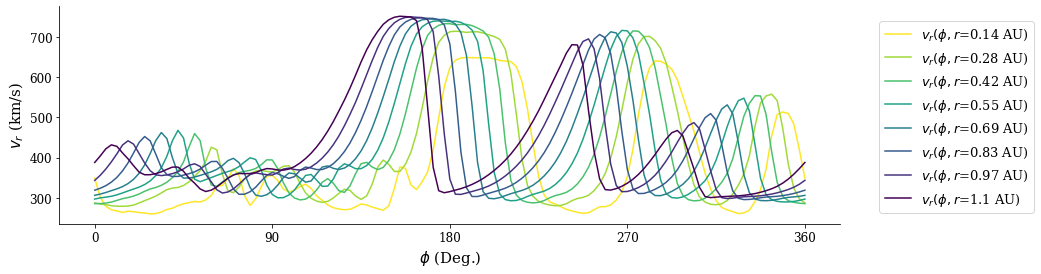

In [14]:
plot_heat_data(V, "", variable=r"$v_{r}$", save_fig=True, file_name="MHD/figs/CR"+ str(cr) +"/original_dataset_MHD.png")

In [15]:
def periodic_corr_np(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return np.correlate(x, np.hstack((y[1:], y)), mode='valid')

def normalize(x):
    return (x - np.mean(x))/np.std(x)

In [16]:
v1 = V[:, 0]
shift_vec = [0]
for ii in range(1, len(r)):
    v2 = V[:, ii]
    corr = periodic_corr_np(normalize(v1), normalize(v2))
    corr = corr/np.max(corr)
    shift_vec.append(p[np.argmax(corr)]*180/np.pi)

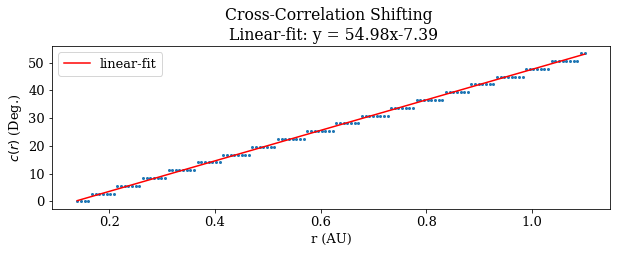

In [17]:
fig, ax = plt.subplots(figsize =(10, 3))
ax.scatter(r.to(u.AU), shift_vec, s=4)

n = int(len(r)*0.5)
m, b = np.polyfit(r[:n].to(u.AU).value, shift_vec[:n], 1)
_ = ax.plot(r.to(u.AU), m*r.to(u.AU).value + b, c="r", label="linear-fit")
_ = ax.legend()
_ = ax.set_xlabel("r (AU)")
_ = ax.set_ylabel("$c(r)$ (Deg.)")
_ = ax.set_title("Cross-Correlation Shifting \n Linear-fit: y = " + str(round(m, 2)) + "x" + str(round(b, 2)))

In [18]:
def shift_function(r, m, b):
    return m * r + b

In [19]:
V_new = np.zeros((len(p), len(r)))

V_new[:, 0] = V[:, 0]

for jj in range(1, len(r)):
    # interpolate on the current eulerian grid. 
    f_interp = interp1d(p*180/np.pi, V[:, jj], fill_value="extrapolate", bounds_error=False)
    # compute shift from the linear fit above. 
    shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
    # define the new shifted coordinate.
    x_new = (p*180/np.pi - shift) % (360)
    # interpolate over the shifted coordinate
    V_new[:, jj] = f_interp(x_new)

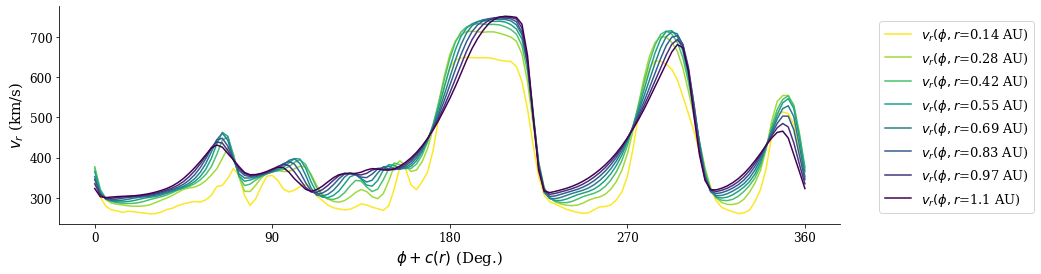

In [20]:
plot_heat_data(V_new, "", variable=r"$v_{r}$", xlabel=r"$\phi + c(r)$ (Deg.)", 
              save_fig=True, file_name="MHD/figs/CR"+ str(cr) +"/shifted_dataset_MHD.png")

# Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [21]:
# set up the first l indexes used for training. 
l = int(0.7*(len(r)))

In [22]:
X= V_new

In [23]:
V_new.shape

(129, 140)

In [24]:
X_train = V_new[:, :l]
X_test = V_new[:, l:-1]

In [25]:
r_train = r[:l]
r_test = r[l:-1]

In [26]:
print("X train shape", np.shape(X_train))
print("Radial distance train: " + str(r[0].to(u.AU)) + " to " + str(r[l].to(u.AU)))
print("\nX test shape", np.shape(X_test))
print("Radial distance test: " + str(r[l].to(u.AU)) + " to " + str(r[-1].to(u.AU)))

X train shape (129, 98)
Radial distance train: 0.13951401782886472 AU to 0.816444039517221 AU

X test shape (129, 41)
Radial distance test: 0.816444039517221 AU to 1.0996495197497314 AU


## Intrusive vs. non-intrustive ROM
* intrusive- ROM operators requires access to the discretized FOM operators.

* nonintrustive -learns ROMs from simulation data without direct access to the FOM operators. 

## Using the ROM Operator Inference Package
Since the FOM has the form
$$
    \frac{d}{dt}\mathbf{x}(t) = A \ln (\mathbf{x}(t)),\qquad\mathbf{x}(0) = \mathbf{x}_0,
$$
we seek a reduced model with that same structure,
$$
    \frac{d}{dt}\hat{\mathbf{x}}(t) = \hat{A}\hat{\mathbf{x}}(t),\qquad\hat{\mathbf{x}}(0) = \hat{\mathbf{x}}_0,
$$

but with $\hat{\mathbf{x}}\in \mathbb{R}^{r}$ and $\hat{A}\in\mathbb{R}^{r\times r}$ for some $r\ll n$. Esentially, we apply the **Dynamic Mode Decomposition (DMD)** method to predict the solar wind proton velocity at several heliocentric distances. 

We have several tasks to consider:
1. Choosing the reduced-model dimension $r$,
2. Constructing a low-dimensional subspace,
3. Computing the right-hand side data matrix $\dot{X}$,
4. Constructing the ROM via Operator Inference,
5. Simulating the ROM, and
6. Evaluating the performance of the ROM.

We will do this quickly, then show each step in more detail.

### Step 1: Choosing the Reduced-model Dimension
There are several ways to choose $r$ in an informed way.
A simple choice is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and select the number of $\sigma_{j}$ that are greater than a given threshold.
This also gives us a sense of whether or not we expect model reduction to be successful: if the singular values do not decay quickly, then we will need many modes to capture the behavior of the system.

In [27]:
svdvals = la.svdvals(X_train)
svdvals_prev = la.svdvals(V[:, :l])

In [28]:
# Calculate the cumulative energy.
thresh = .993
cum_energy = np.cumsum(svdvals) / np.sum(svdvals)
cum_energy_prev = np.cumsum(svdvals_prev) / np.sum(svdvals_prev)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
rank_prev = sum([rank < thresh for rank in cum_energy_prev])
print(f"r (Shifted coordinates)= {rank}")
print(f"r (Eularian coordinates)= {rank_prev}")

r (Shifted coordinates)= 5
r (Eularian coordinates)= 10


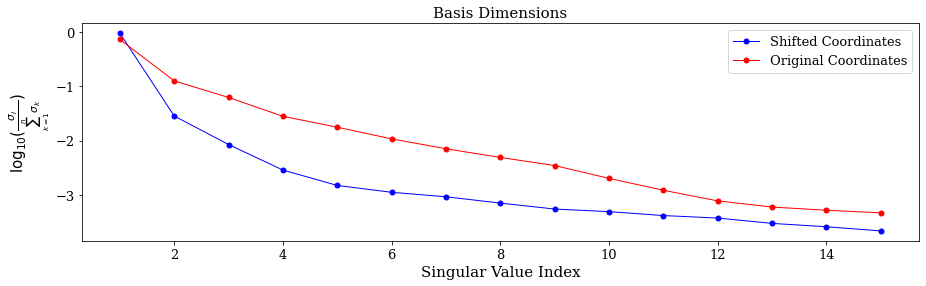

In [29]:
#Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(15, 4))
#plot singluar values cumulative energy
ax.plot(np.arange(1, 16), np.log10(svdvals[:15]/ np.sum(svdvals)), '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, 16), np.log10(svdvals_prev[:15]/ np.sum(svdvals_prev)), '.-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")


plt.legend()
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"$\log_{10}(\frac{\sigma_{i}}{\sum_{k=1}^{n} \sigma_{k}})$", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)

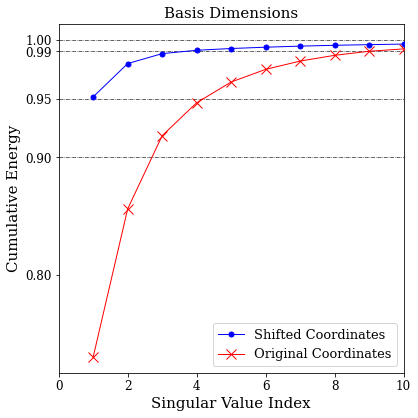

In [30]:
# Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(6, 6))

xlim= 10

# plot singluar values cumulative energy
ax.plot(np.arange(1, svdvals.size + 1), cum_energy, '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, svdvals.size + 1), cum_energy_prev, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")
# get current y-limits 
ylim = ax.get_ylim()
# plot vertical and horizontal lines based on threshhold value
#ax.vlines(rank, 0, thresh, color="blue", linewidth=.6, linestyle="-.")
#ax.vlines(rank_prev, 0, thresh, color="red", linewidth=.6, linestyle="-.")


# set up axis. 
ax.hlines(0.9, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.95, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.99, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(1, 0, xlim, color="black", linewidth=.6, linestyle="-.")

plt.legend()
_ = ax.set_ylim(ylim)
_ = ax.set_xlim(0, xlim)
_ = ax.set_yticks(ticks=[0.8, 0.9, 0.95, 0.99, 1])
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"Cumulative Energy", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()     
plt.savefig("figs/singular_value_decay.png", pad_inches=1)

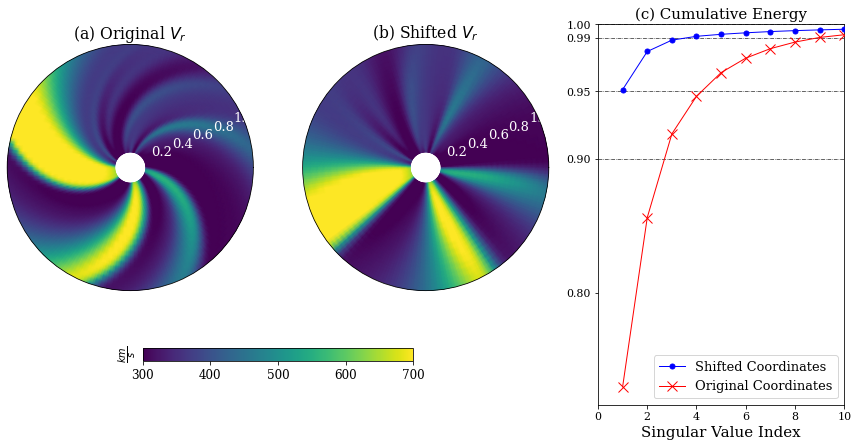

In [31]:
fig=plt.figure(figsize=(15, 7))
ax = fig.add_subplot(131, polar=True)
ax.set_rlim(0)
ax.set_thetalim(0, 2 * np.pi)
ax.set_xticks([])
ax.set_ylim(0,1.1)
rlabels = ax.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax.pcolormesh(p, r.to(u.AU).value, V.T, vmin=300, vmax=700, shading='gouraud', cmap="viridis")
ax.set_title("(a) Original $V_{r}$")
ax1 = fig.add_subplot(132, polar=True)
ax1.set_rlim(0)
ax1.set_thetalim(0, 2 * np.pi)
ax1.set_xticks([])

ax1.set_ylim(0,1.1)
rlabels = ax1.get_ymajorticklabels()
for label in rlabels:
    label.set_color('white')

pos = ax1.pcolormesh(p, r.to(u.AU).value, V_new.T, vmin=300, vmax=700, shading='gouraud', cmap="viridis")

cbar = fig.colorbar(pos, ax=(ax1, ax), orientation="horizontal", shrink=0.5)
cbar.ax.set_ylabel(r'$\frac{km}{s}$', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)
_ = ax1.set_title("(b) Shifted $V_{r}$")

ax = fig.add_subplot(133)

xlim= 10

# plot singluar values cumulative energy
ax.plot(np.arange(1, svdvals.size + 1), cum_energy, '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, svdvals.size + 1), cum_energy_prev, 'x-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")
# get current y-limits 
ax.set_ylim(top=1)
ylim = ax.get_ylim()

# set up axis. 
ax.hlines(0.9, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.95, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(0.99, 0, xlim, color="black", linewidth=.6, linestyle="-.")
ax.hlines(1, 0, xlim, color="black", linewidth=.6, linestyle="-.")

plt.legend()
_ = ax.set_ylim(ylim)
_ = ax.set_xlim(0, xlim)
_ = ax.set_yticks(ticks=[0.8, 0.9, 0.95, 0.99, 1])
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
#_ = ax.set_ylabel(r"Cumulative Energy", fontsize=15)
_ = ax.set_title("(c) Cumulative Energy", fontsize=15)
_ = ax.tick_params(axis='both', which='major', labelsize=11)


plt.savefig("MHD/figs/1D_MHD_shifted-comparison.png", dpi=600)

### Constructing a Low-dimensional Subspace
Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined.
One of the most standard strategies, which aligns with our analysis of the singular values of $X$, is the _POD basis of rank $r$_ corresponding to $X$.
If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $X$:
$$
V_{r} := \Phi_{:,:r}.
$$

In [32]:
Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (129, 5)


To get a sense of the kinds of solutions we may see, we plot the columns of $V_r$.
All solutions of the resulting ROM can only be linear combinations of these columns.

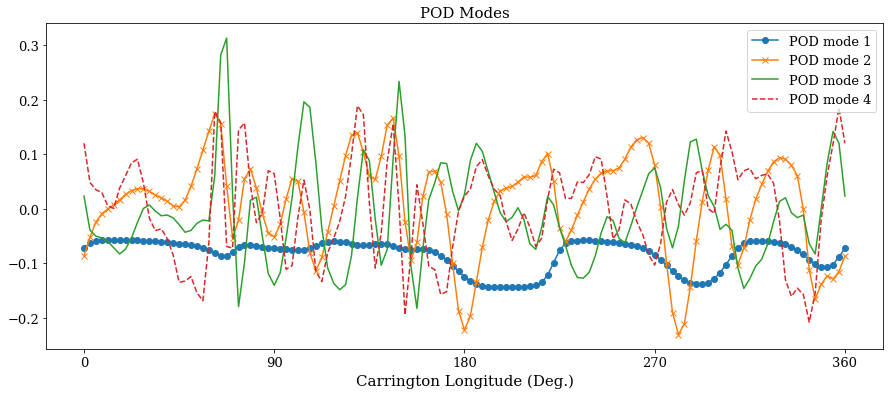

In [33]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot((180/np.pi) * p, Vr[:len(p),0], "-o", label=f"POD mode {1}")
ax.plot((180/np.pi) * p, Vr[:len(p),1], "-x", label=f"POD mode {2}")
ax.plot((180/np.pi) * p, Vr[:len(p),2], "-", label=f"POD mode {3}")
ax.plot((180/np.pi) * p, Vr[:len(p),3], "--", label=f"POD mode {4}")
#ax.plot((180/np.pi) * p_new, Vr[:len(p_new),4], "-", label=f"POD mode {5}")


    
ax.set_xlabel("Carrington Longitude (Deg.)", fontsize=15)
ax.set_title("POD Modes", fontsize=15)
ax.set_xticks([0, 90, 180, 270, 360])
plt.legend(loc="upper right")
plt.show()

In [34]:
roi.pre.projection_error(X_train, Vr)

0.002062193816222322

### Calculating the right-hand side Data Matrix

Operator Inference constructs the ROM by solving a least-squares problem that corresponds to the form of the model.
In this case, the original model has the form $\frac{d}{dt}\mathbf{x}(t) = A\mathbf{x}(t)$.
The snapshot matrix $X$ contains data for $\mathbf{x}(t)$, but we also need data for $\frac{d}{dt}\mathbf{x}(t)$.
In this simple example, we can directly compute the _snapshot time derivative matrix_ $\dot{X}\in\mathbb{R}^{n\times k}$ that corresponds to the snapshots by setting $\dot{X} = A X$.

\If the matrix $A$ is unknown or computationally unavailable, the time derivative matrix can be estimated through finite differences of the snapshots.
The `pre` submodule has some convenience tools for this.
Since our time domain is uniformly spaced, we use `roi.pre.xdot_uniform()`; for snapshots that are not uniformly spaced in time, see `roi.pre.xdot_nonuniform()`.

We also note that the finite difference approximation for $\dot{X}$ commutes with the projection to a low-dimensional subspace; in other words, $V_{r}^\mathsf{T}\frac{d}{dt}\left[X\right] = \frac{d}{dt}\left[V_{r}^\mathsf{T}X\right]$.
To save memory, the snapshot matrix may be projected first, and the projected time derivatives can be calculated from the projected snapshots.
The ROM classes in the next section accept both full-order ($n \times k$) or reduced-order ($r\times k$) snapshot and time derivative matrices as training data.

In [35]:
X_ = Vr.T @ X_train                                  # Project the state snapshots.
Xdot_ = roi.pre.xdot_uniform(X_, (r[1]-r[0]).value, order = 6) # Estimate the projected time derivatives.

In [36]:
model = roi.InferredContinuousROM("A")
print(model)

Reduced-order model structure: dx / dt = Ax(t)


We now fit the model to the data by solving the least squares problem
$$
    \min_{\hat{A}\in\mathbb{R}^{r\times r}}\left\|\hat{A}\hat{X} - \dot{\hat{X}}\right\|_{F}^2,
$$
where
$$
\begin{align*}
    \hat{X} &= V_r^\mathsf{T}X,
    &
    \dot{\hat{X}} &= V_r^\mathsf{T}\dot{X}.
\end{align*}
$$
This is all done in the `fit()` method, given $X$, $\dot{X}$, and $V_r$.

In [37]:
model.fit(Vr, X_train, Xdot_, P=1e3)

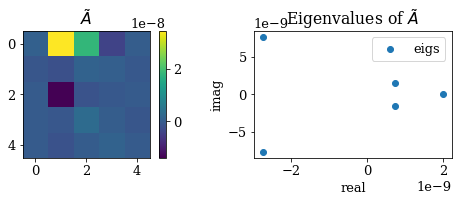

In [38]:
fig, ax = plt.subplots(ncols=2, figsize=(7, 3))
pos = ax[0].imshow(model.A_)
cbar = fig.colorbar(pos, ax=ax[0])
_ = ax[0].set_title(r"$\tilde A$")

# eigendecomposition of A. 
eigA, eigvecA = np.linalg.eig(model.A_)

_ = ax[1].scatter(eigA.real, eigA.imag, label="eigs")
_ = ax[1].set_xlabel("real")
_ = ax[1].set_ylabel("imag")
_ = ax[1].set_title("Eigenvalues of " + r"$\tilde A$")
_ = plt.legend()
_ = plt.tight_layout()

### Simulating the Reduced Model
Once the model is fit, we may simulate the ROM with the `predict()` method, which wraps `scipy.integrate.solve_ivp()`.
This method takes an initial condition from the original space $\mathbb{R}^n$, projects it to $\mathbb{R}^r$, simulates the ROM in $\mathbb{R}^r$, and maps the results to $\mathbb{R}^n$.

In [39]:
X_ROM = model.predict(X[:, 0], r.value, method="BDF")
X_ROM.shape

(129, 140)

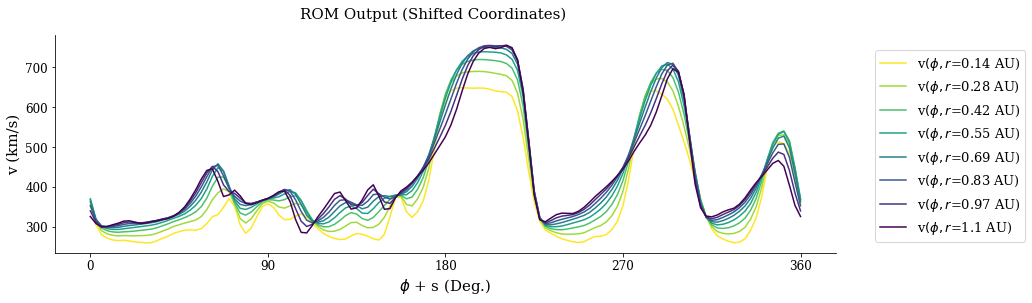

In [40]:
plot_heat_data(X_ROM, "ROM Output (Shifted Coordinates)", variable="v", xlabel=r"$\phi$ + s (Deg.)")

### Evaluating the Performance of the ROM

To see how the ROM does, we begin by visualizing the simulation output `X_ROM`.
It should look similar to the plot of the snapshot data `X`.

In [41]:
def convert_from_x_to_v(X_ROM):
    V_ROM = np.zeros(X_ROM.shape)
    V_ROM[:, 0] = X_ROM[:, 0]
    for jj in range(1, len(r)):
        # interp on eulerian corrdinates. 
        f_interp = interp1d(p, X_ROM[:, jj], fill_value="extrapolate", bounds_error=False)
        # find shift based on linear fit.
        shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
        # shifted coordinates.
        x_new = (p + shift*np.pi/180) % (2*np.pi)
        # interpolate over shifted coords. 
        V_ROM[:, jj] = f_interp(x_new)
    return V_ROM

In [42]:
V_ROM = convert_from_x_to_v(X_ROM)

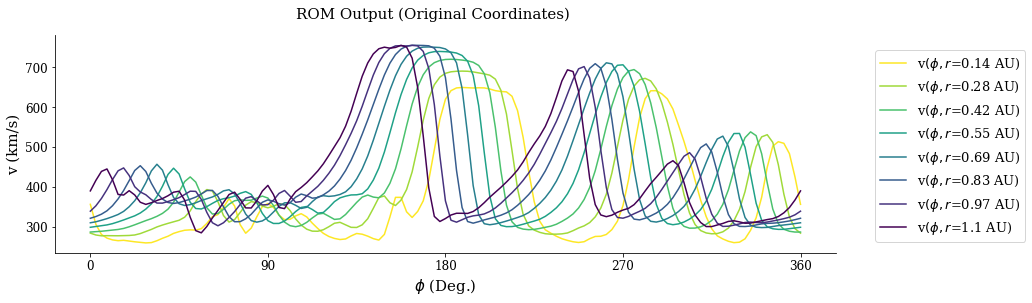

In [43]:
plot_heat_data(V_ROM, "ROM Output (Original Coordinates)", variable="v")

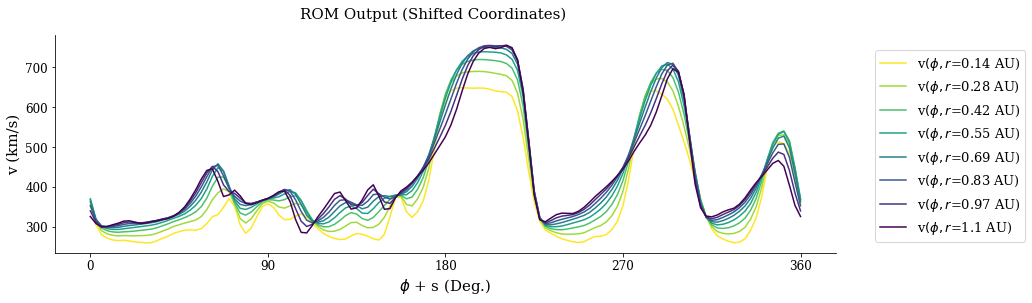

In [44]:
plot_heat_data(X_ROM, "ROM Output (Shifted Coordinates)", variable="v", xlabel=r"$\phi$ + s (Deg.)")

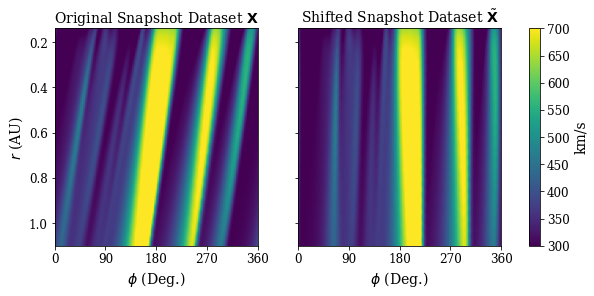

In [45]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
pos = ax[0].imshow(V.T, extent=[0,360,r[-1].to(u.AU).value, r[0].to(u.AU).value], aspect="auto", vmin=300, vmax=700)
_ = ax[0].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
_ = ax[0].set_ylabel(r"$r$ (AU)", fontsize=14)
_ = ax[0].set_xticks([0, 90, 180, 270, 360])
_ = ax[1].set_title("Shifted Snapshot Dataset " + r"$\tilde{\mathbf{X}}$", fontsize=14)
_ = ax[0].tick_params(axis='both', which='major', labelsize=12)


pos = ax[1].imshow(X.T, extent=[0,360,r[-1].to(u.AU).value, r[0].to(u.AU).value], aspect="auto", vmin=300, vmax=700)
cbar = fig.colorbar(pos, ax=ax)
cbar.ax.set_ylabel('km/s', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)
_ = ax[1].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
_ = ax[1].set_xticks([0, 90, 180, 270, 360])
_ = ax[0].set_title("Original Snapshot Dataset " + r"$\mathbf{X}$", fontsize=14)
_ = ax[1].tick_params(axis='both', which='major', labelsize=12)


#plt.savefig("figs/equator_velocity_profile_shifted_and_original.png", bbox_inches="tight", dpi=800)

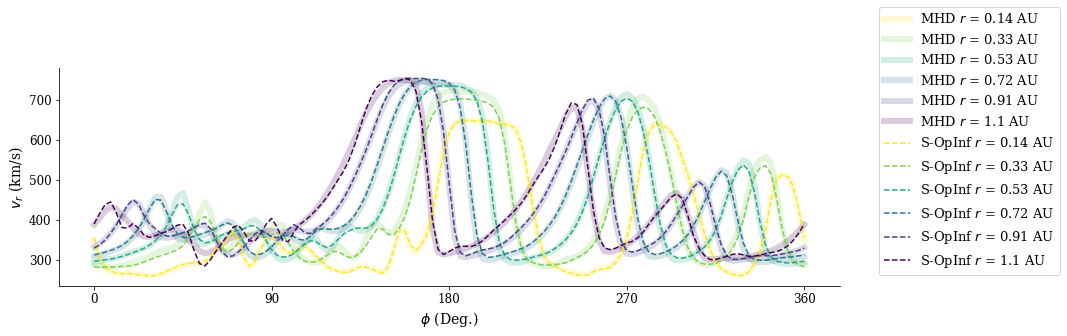

In [46]:
sample_columns = np.arange(0, len(r), int(len(r)//5))
sample_columns = np.append(sample_columns, len(r) -1)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    ax.plot(p*(180/np.pi), V[:,j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"MHD $r$ = "+
            str(round(r[j].to(u.AU).value,2)) + " AU")
    
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))
for j in sample_columns:
    curr_color =next(color)    
    ax.plot(p*(180/np.pi), V_ROM[:,j], "--", color=curr_color, label=r"S-OpInf $r$ = " + 
            str(round(r[j].to(u.AU).value,2)) + " AU")

ax.set_xlabel("$\phi$ (Deg.)", fontsize=14)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_ylabel("$v_{r}$ (km/s)", fontsize=14)
ax.legend(loc=(1.05, .05))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#fig.suptitle("Shifted Operator Inference \n" + str(model), fontsize=14)
_ = ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig("MHD/figs/CR2210/A/shifted_opinf_results_mhd_A_1D.png", dpi=500, bbox_inches='tight')


For more detail, we evaluate the $\ell^2$ error of the ROM output in time, comparing it to the snapshot set.

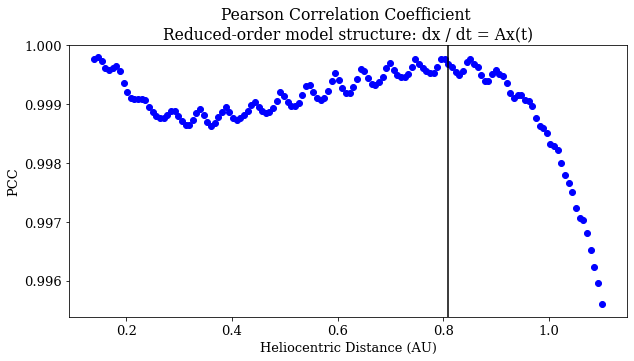

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))
for jj in range(len(r)):
    pcc = stats.pearsonr(V[:, jj], V_ROM[:, jj])[0]
    ax.scatter(r.to(u.AU).value[jj], pcc, c="b")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
_ = ax.set_title("Pearson Correlation Coefficient \n" + str(model))

plt.savefig("figs/pcc_shifted_operator_inference_mhd_A.png")

In [48]:
print("2d pcc = ", stats.pearsonr(np.ndarray.flatten(V), np.ndarray.flatten(V_ROM))[0])

2d pcc =  0.997809975043368


In [49]:
print("2d pcc training = ", stats.pearsonr(np.ndarray.flatten(V[:, :l]), np.ndarray.flatten(V_ROM[:, :l]))[0])

2d pcc training =  0.9979541049828458


In [50]:
print("2d pcc training = ", stats.pearsonr(np.ndarray.flatten(V[:, l:]), np.ndarray.flatten(V_ROM[:, l:]))[0])

2d pcc training =  0.9985389528036329


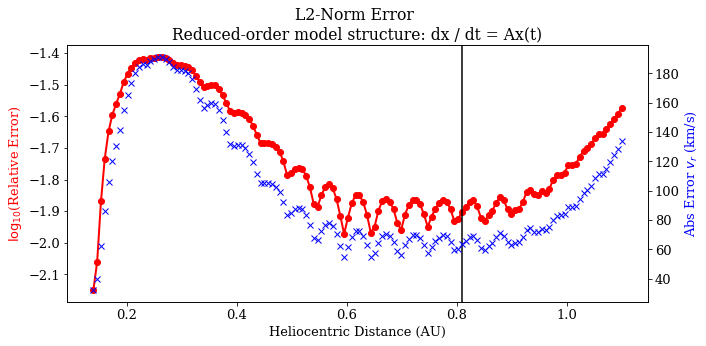

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2errA, rel_l2errA = roi.post.lp_error(V, V_ROM)
_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2errA),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title("L2-Norm Error \n" + str(model))
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r.to(u.AU).value, abs_l2errA, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()
plt.savefig("figs/L2_error_operator_inference_mhd_A.png", dpi=300)

In [52]:
abs_froerr, rel_froerr = roi.post.frobenius_error(V, V_ROM)
print(f"Relative error: {rel_froerr:%}")

Relative error: 2.163560%


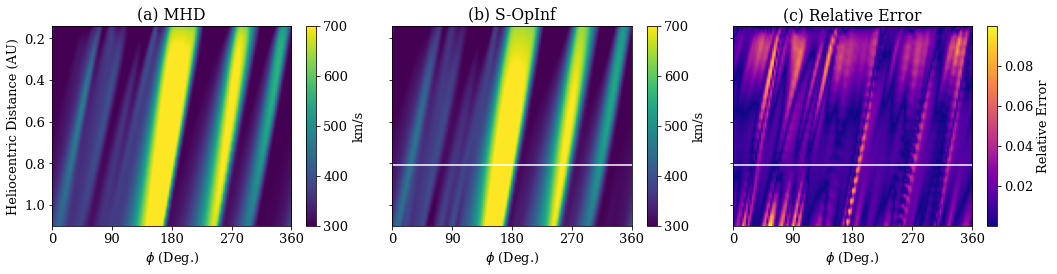

In [53]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 4))
pos = ax[0].imshow(V.T, extent=[0,360,r[-1].to(u.AU).value, 
                                r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"Heliocentric Distance (AU)")
ax[0].set_title("(a) MHD")
ax[0].set_xticks([0, 90, 180, 270, 360])
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[0,360,r[-1].to(u.AU).value, 
                                    r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_title("(b) S-OpInf")
ax[1].set_xticks([0, 90, 180, 270, 360])
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(np.abs(V_ROM.T - V.T)/np.abs(V.T), 
                   extent=[0,360,r[-1].to(u.AU).value, r[0].to(u.AU).value], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_title("(c) Relative Error")
ax[2].set_xticks([0, 90, 180, 270, 360])
ax[2].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error', rotation=90)

#plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()
plt.savefig("MHD/figs/CR2210/A/Relative_Error_MHD_A_1D.png", dpi=600)

In [54]:
print("mean relative error = ", np.mean(np.abs((V- V_ROM))/np.abs(V)))

mean relative error =  0.016616343713081797


# Streamlines Comparison

In [55]:
def compute_phi_shift_forward(p, r, v, omega=2*np.pi/25.38, method=None):
    # initialize phi shift matrix. 
    phi_shift_mat = np.zeros((len(r), len(p)))
    
    # phi at index 0 is original phi grid 
    phi_shift_mat[0, :] = p
    
    # delta r.
    dr = np.mean(r[1:] - r[:-1])
    
    # compute the phi shift for each idx in r. 
    for ii in range(len(r)-1):
        if method == "ballistic":
            phi_shift = -(omega/v[:, 0])*dr
        else:
            phi_shift = -(omega/v[:, ii])*dr
        phi_shift_mat[ii+1, :] = phi_shift_mat[ii, :] + phi_shift
        
    return phi_shift_mat 

In [56]:
def cmap():
    # an array of parameters, each of our curves depend on a specific value of parameters.
    parameters = np.linspace(0,2*np.pi,len(p))
    # norm is a class which, when called, can normalize data into the [0.0, 1.0] interval.
    norm = matplotlib.colors.Normalize(vmin=np.min(parameters), vmax=np.max(parameters))
    # create a ScalarMappable and initialize a data structure
    arr = matplotlib.cm.ScalarMappable(cmap=matplotlib.cm.hsv, norm=norm)
    arr.set_array([])
    return arr

In [58]:
def cdf(data, ax, label, ls):
    data_size=len(data)
    # Set bins edges
    data_set=sorted(set(data))
    bins=np.append(data_set, data_set[-1]+1)
    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts=counts.astype(float)/data_size
    # Find the cdf
    cdf = np.cumsum(counts)
    # Plot the cdf
    ax.plot(bin_edges[:-1], cdf, ls=ls, label=label)

In [59]:
U_MHD = (V*u.km/u.second).to(u.AU/u.day).value
U_HUX = (V_HUX*u.km/u.second).to(u.AU/u.day).value
U_OpInf = (V_ROM*u.km/u.second).to(u.AU/u.day).value

In [60]:
phi_shift_mhd = compute_phi_shift_forward(p, r.to(u.AU).value, U_MHD)
phi_shift_hux = compute_phi_shift_forward(p, r.to(u.AU).value, U_HUX)
phi_shift_sopinf = compute_phi_shift_forward(p, r.to(u.AU).value, U_OpInf)

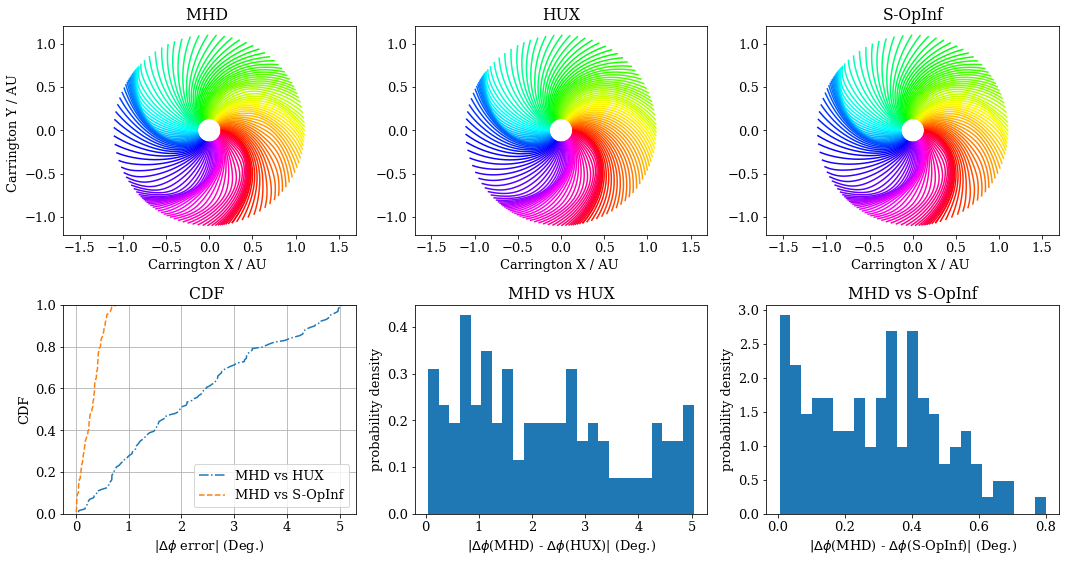

In [62]:

s_m = cmap()

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 8))
for ii in range(len(p)):
    _ = ax[0, 0].plot(np.cos(phi_shift_mhd[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_mhd[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))
    _ = ax[0, 1].plot(np.cos(phi_shift_hux[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_hux[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))
    _ = ax[0, 2].plot(np.cos(phi_shift_sopinf[:, ii])*r.to(u.AU).value, 
                np.sin(phi_shift_sopinf[:, ii])*r.to(u.AU).value, 
                color=s_m.to_rgba(p[ii]))
    
_ = ax[0, 0].set_title("MHD ")
_ = ax[0, 0].set_xlabel("Carrington X / AU ")
_ = ax[0, 0].set_ylabel("Carrington Y / AU ")
_ = ax[0, 0].axis("equal")

_ = ax[0, 1].set_title("HUX")
_ = ax[0, 1].set_xlabel("Carrington X / AU ")
_ = ax[0, 1].axis("equal")

_ = ax[0, 2].set_title("S-OpInf")
_ = ax[0, 2].set_xlabel("Carrington X / AU ")
_ = ax[0, 2].axis("equal")

diff_hux = (180./np.pi)*np.abs(phi_shift_mhd[-1] - phi_shift_hux[-1])
mu, sigma = stats.norm.fit(diff_hux)
n , bins, _ = ax[1, 1].hist(np.abs(diff_hux), 25, density=1)

_ = ax[1, 1].set_title("MHD vs HUX")
_ = ax[1, 1].set_xlabel("$|\Delta \phi$(MHD) - $\Delta \phi$(HUX)| (Deg.)")
_ = ax[1, 1].set_ylabel("probability density") 



diff_rom = (180./np.pi)*np.abs(phi_shift_mhd[-1] - phi_shift_sopinf[-1])
mu, sigma = stats.norm.fit(diff_rom)
n , bins, _ = ax[1, 2].hist(np.abs(diff_rom), 25, density=1)

_ = ax[1, 2].set_title("MHD vs S-OpInf")
_ = ax[1, 2].set_xlabel("$|\Delta \phi$(MHD) - $\Delta \phi$(S-OpInf)| (Deg.)")
_ = ax[1, 2].set_ylabel("probability density") 


cdf(diff_hux, ax[1, 0], label = "MHD vs HUX", ls="-.")
cdf(diff_rom, ax[1, 0], label = "MHD vs S-OpInf", ls="--")
ax[1, 0].set_ylim((0,1))
ax[1, 0].set_ylabel("CDF")
ax[1, 0].set_xlabel("|$\Delta \phi$ error| (Deg.)")
ax[1, 0].grid(True)
ax[1, 0].set_title("CDF ")
_ = ax[1, 0].legend()

plt.tight_layout()
plt.savefig('MHD/figs/MHD_HUX_OpInf_streamlines.png')

# Can we improve prediction by regularization? to avoid overfitting to the training dataset. Find the optimal regularization coefficient $\lambda_{1}$

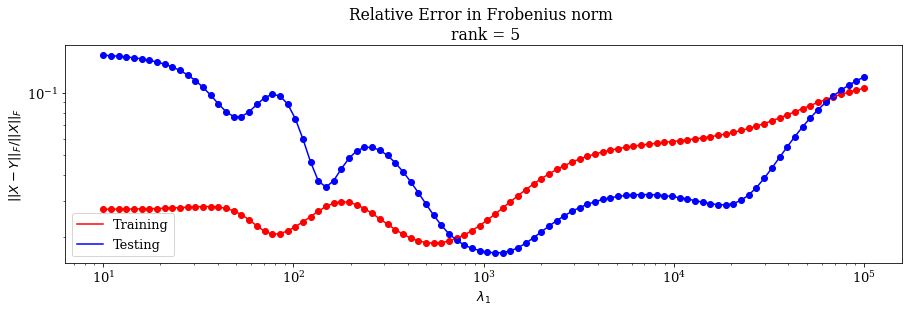

In [52]:
fig, ax = plt.subplots(figsize=(15, 4))

coeff_array = 10**np.linspace(1, 5, 100)

training_error = np.ones((2, len(coeff_array))) * np.inf
testing_error = np.ones((2, len(coeff_array))) * np.inf

for kk, coeff in enumerate(coeff_array):
    
    Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)   # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=coeff)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = convert_from_x_to_v(X_ROM)
        # save
        training_error[0, kk] = coeff
        training_error[1, kk] = roi.post.frobenius_error(V[:, :l], V_ROM[:, :l])[1]
        # save
        testing_error[0, kk] = coeff
        testing_error[1, kk] = roi.post.frobenius_error(V[:, l:], V_ROM[:, l:])[1]
        
ax.plot(training_error[0, :], training_error[1, :],  c="r", label="Training")
ax.scatter(training_error[0, :], training_error[1, :],  c="r")
ax.plot(testing_error[0, :], testing_error[1, :],  c="b", label="Testing")
ax.scatter(testing_error[0, :], testing_error[1, :],  c="b")

_ = plt.xscale("log")
_ = plt.yscale("log")
_ = ax.set_xlabel("$\lambda_{1}$")
_ = ax.set_ylabel("$||X - Y||_{F} / ||X||_{F}$")
_ = ax.set_title("Relative Error in Frobenius norm \n rank = " + str(rank))
_ = plt.legend()

In [53]:
optimal_reg = testing_error[0, np.argmin(testing_error[1, :])]
print("Optimal Regularization Coefficent = ", optimal_reg)

Optimal Regularization Coefficent =  1149.7569953977368


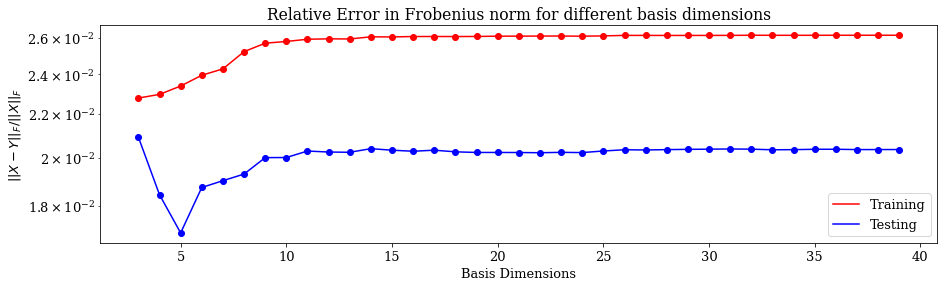

In [54]:
fig, ax = plt.subplots(figsize=(15, 4))

rank_array = np.arange(3, 40)

training_error = np.ones((2, len(coeff_array))) *np.inf
testing_error = np.ones((2, len(coeff_array))) *np.inf

for kk, r_val in enumerate(rank_array):
    Vr, _ = roi.pre.pod_basis(X_train, r=r_val)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)   # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=1e3)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = convert_from_x_to_v(X_ROM)
        # save
        training_error[0, kk] = r_val
        training_error[1, kk] = roi.post.frobenius_error(V[:, :l], V_ROM[:, :l])[1]
        # save
        testing_error[0, kk] = r_val
        testing_error[1, kk] = roi.post.frobenius_error(V[:, l:], V_ROM[:, l:])[1]
        
    
        
ax.plot(training_error[0, :], training_error[1, :],  c="r", label="Training")
ax.scatter(training_error[0, :], training_error[1, :],  c="r")
ax.plot(testing_error[0, :], testing_error[1, :],  c="b", label="Testing")
ax.scatter(testing_error[0, :], testing_error[1, :],  c="b")

#_ = plt.xscale("log")
_ = plt.yscale("log")
_ = ax.set_xlabel("Basis Dimensions")
_ = ax.set_ylabel("$||X - Y||_{F} / ||X||_{F}$")
_ = ax.set_title("Relative Error in Frobenius norm for different basis dimensions")
_ = plt.legend()

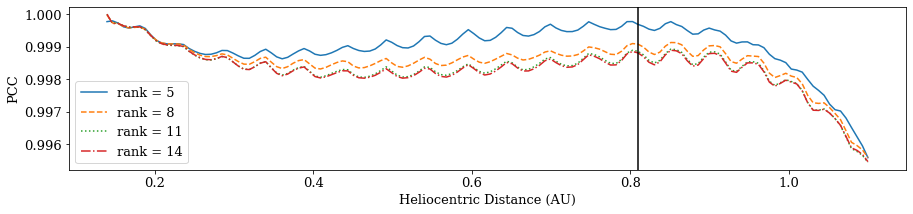

In [115]:
fig, ax = plt.subplots(figsize=(15, 3))

ls_list = ["-", "--", ":", "-.", "solid"]

for ii, r_val in enumerate(np.arange(5, 15,3)):# get the svd rank based on total cumulative energy. 
    Vr, _ = roi.pre.pod_basis(X_train, r=r_val)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=1e3)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = convert_from_x_to_v(X_ROM)
        pcc_vec = np.zeros(len(r))
        for jj in range(len(r)):
            pcc_vec[jj] = stats.pearsonr(V[:, jj], V_ROM[:, jj])[0]
        
        ax.plot(r.to(u.AU).value, pcc_vec, label="rank = " + str(int(r_val)), linestyle=ls_list[ii])
        
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
#_ = ax.set_title("Pearson Correlation Coefficient (PCC)")
plt.legend()


fig.savefig("MHD/figs/CR2210/A/pcc_rank_MHD_A_1D.png", dpi=500, bbox_inches='tight')

# Quadratic ROM

In [56]:
# Calculate the cumulative energy.
thresh = .993

cum_energy = np.cumsum(svdvals) / np.sum(svdvals)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
print(f"r = {rank}")

r = 5


In [57]:
Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)            # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
model.fit(Vr, X_train, Xdot, P=5e6)                          # Construct the ROM with Operator Inference.
X_ROM = model.predict(X[:, 0], r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.

In [58]:
V_ROM = convert_from_x_to_v(X_ROM)

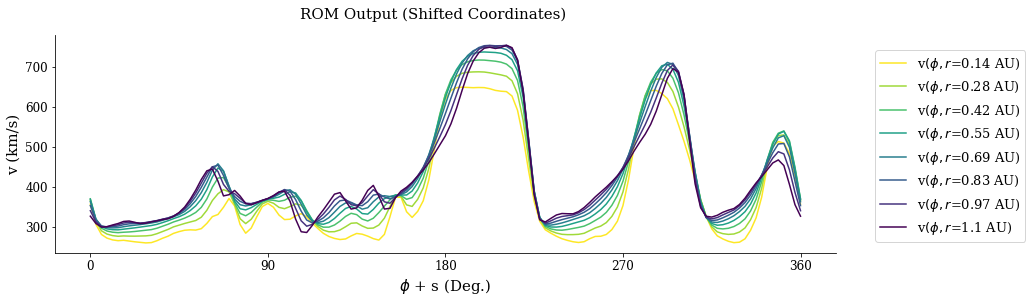

In [59]:
plot_heat_data(X_ROM, "ROM Output (Shifted Coordinates)", variable="v", xlabel="$\phi$ + s (Deg.)")

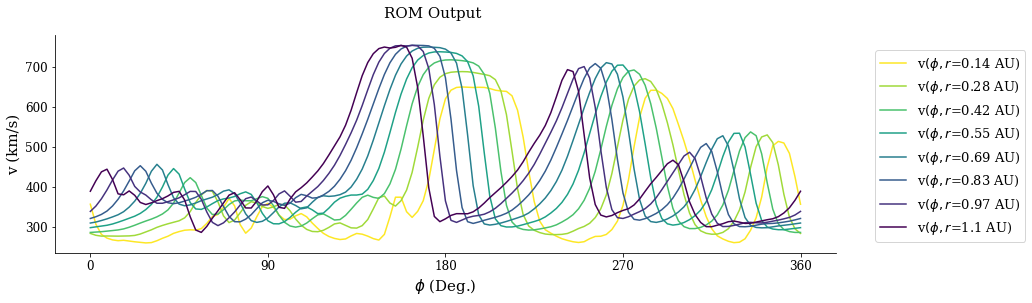

In [60]:
plot_heat_data(V_ROM, "ROM Output", variable="v")

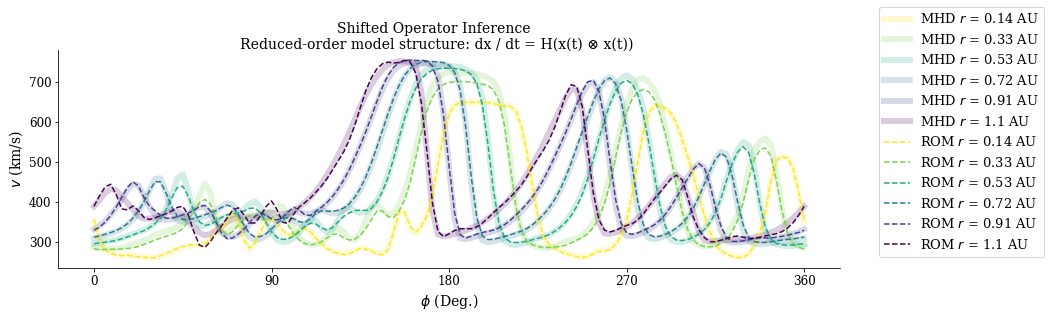

In [61]:
sample_columns = np.arange(0, len(r), int(len(r)//5))
sample_columns = np.append(sample_columns, len(r) -1)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))

for j in sample_columns:
    curr_color =next(color)
    ax.plot(p*(180/np.pi), V[:,j], color=curr_color, linewidth=6.0, alpha=0.2, label=r"MHD $r$ = "+
            str(round(r[j].to(u.AU).value,2)) + " AU")
    
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(sample_columns))))
for j in sample_columns:
    curr_color =next(color)    
    ax.plot(p*(180/np.pi), V_ROM[:,j], "--", color=curr_color, label=rf"ROM $r$ = " + 
            str(round(r[j].to(u.AU).value,2)) + " AU")

ax.set_xlabel("$\phi$ (Deg.)", fontsize=14)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_ylabel("$v$ (km/s)", fontsize=14)
ax.legend(loc=(1.05, .05))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
fig.suptitle("Shifted Operator Inference \n" + str(model), fontsize=14)
_ = ax.tick_params(axis='both', which='major', labelsize=12)

fig.savefig("figs/shifted_opinf_results_mhd_H.png", dpi=500, bbox_inches='tight')

In [62]:
V.shape

(129, 140)

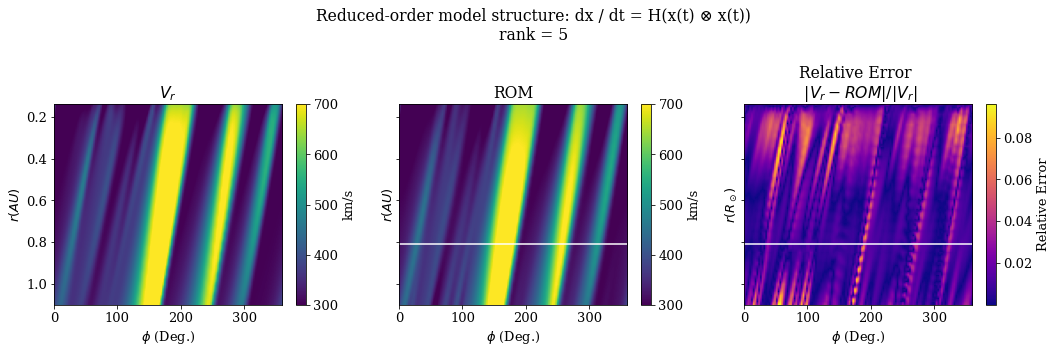

In [63]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
pos = ax[0].imshow(V.T, extent=[0,360, r[-1].to(u.AU).value, 
                                r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[0].set_xlabel(r"$\phi$ (Deg.)")
ax[0].set_ylabel(r"$r (AU)$")
ax[0].set_title("$V_{r}$")
cbar = fig.colorbar(pos, ax=ax[0])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[1].imshow(V_ROM.T, extent=[0,360, r[-1].to(u.AU).value, 
                                    r[0].to(u.AU).value], vmax=700, vmin=300, aspect="auto")
ax[1].set_xlabel(r"$\phi$ (Deg.)")
ax[1].set_ylabel(r"$r (AU)$")
ax[1].set_title("ROM")
ax[1].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[1])
cbar.ax.set_ylabel('km/s', rotation=90)

pos = ax[2].imshow(np.abs(V_ROM.T - V.T)/np.abs(V.T), extent=[0,360,r[-1].to(u.AU).value, r[0].to(u.AU).value], 
                   cmap="plasma", aspect="auto")
ax[2].set_xlabel(r"$\phi$ (Deg.)")
ax[2].set_ylabel(r"$r (R_\odot)$")
ax[2].set_title("Relative Error \n $|V_{r} - ROM|/|V_{r}|$")
ax[2].plot(p*(180/np.pi), r_train[-1].to(u.AU).value * np.ones(len(p)), c="white")
cbar = fig.colorbar(pos, ax=ax[2])
cbar.ax.set_ylabel('Relative Error', rotation=90)

plt.suptitle(str(model) + "\n" + "rank = " + str(rank))

plt.tight_layout()

fig.savefig("figs/shifted_opinf_results_quadratic_2D_profile_H.png", dpi=500, bbox_inches='tight')

In [64]:
print("mean relative error = ", np.mean(np.abs((V.T - V_ROM.T))/np.abs(V.T)))

mean relative error =  0.01668290922051678


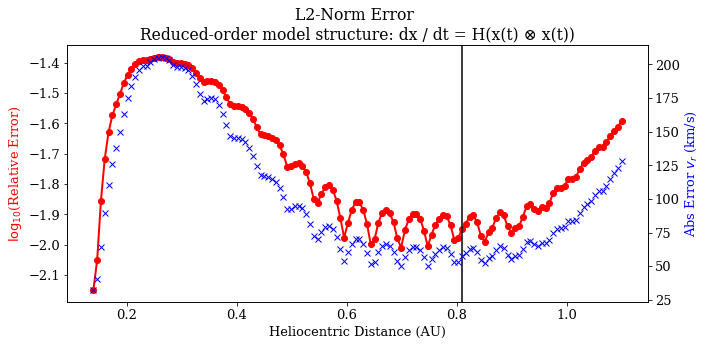

In [65]:
fig, ax = plt.subplots(figsize=(10, 5))
abs_l2errH, rel_l2errH = roi.post.lp_error(V, V_ROM)
_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2errH),"-o", linewidth=2, c="r")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title("L2-Norm Error \n" + str(model))
_ = ax.set_ylabel("$\log_{10}$(Relative Error)", c="r")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

ax2=ax.twinx()
_ = ax2.plot(r.to(u.AU).value, abs_l2errH, "x", linewidth=2, c="b")
_ = ax2.set_ylabel("Abs Error $v_{r}$ (km/s)", c="b")

plt.tight_layout()

plt.savefig("figs/L2_error_operator_inference_mhd_H.png", dpi=300)

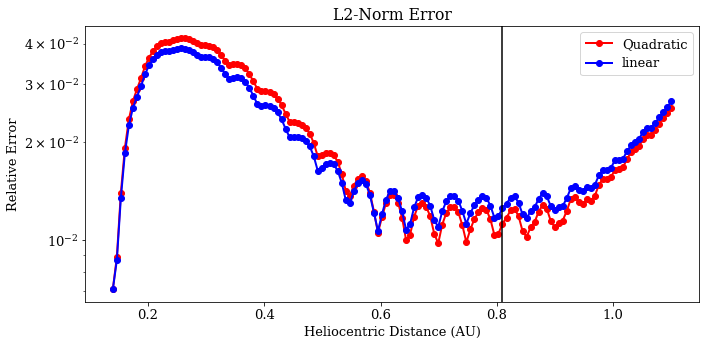

In [66]:
fig, ax = plt.subplots(figsize=(10, 5))


_ = ax.plot(r.to(u.AU).value, rel_l2errH,"-o", linewidth=2, c="r", label="Quadratic")
_ = ax.plot(r.to(u.AU).value, rel_l2errA,"-o", linewidth=2, c="b", label="linear")

_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_title("L2-Norm Error")
_ = ax.set_ylabel("Relative Error", c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

plt.yscale("log")
plt.tight_layout()
plt.legend()

plt.savefig("figs/L2_error_operator_inference_mhd_A_vs_H.png", dpi=300)

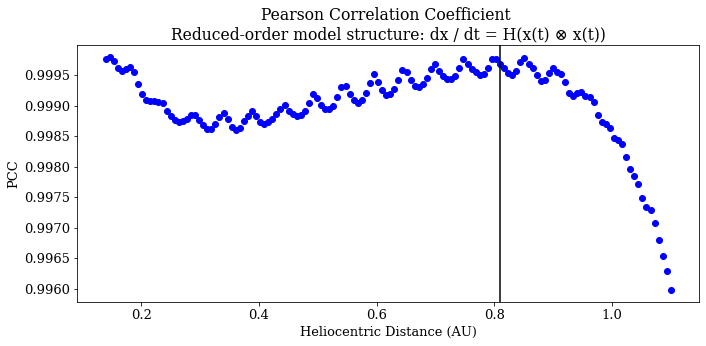

In [67]:
fig, ax = plt.subplots(figsize=(10, 5))
for jj in range(len(r)):
    pcc = stats.pearsonr(V[:, jj], V_ROM[:, jj])[0]
    ax.scatter(r.to(u.AU).value[jj], pcc, c="b")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
_ = ax.set_title("Pearson Correlation Coefficient \n" + str(model))

plt.tight_layout()
plt.savefig("figs/pcc_shifted_operator_inference_mhd_H.png", dpi=300)

In [68]:
print("2d pcc = ", stats.pearsonr(np.ndarray.flatten(V), np.ndarray.flatten(V_ROM))[0])

2d pcc =  0.9977268314983716


In [69]:
print("2d pcc training = ", stats.pearsonr(np.ndarray.flatten(V[:, :l]), np.ndarray.flatten(V_ROM[:, :l]))[0])

2d pcc training =  0.9978580461072057


In [70]:
print("2d pcc testing = ", stats.pearsonr(np.ndarray.flatten(V[:, l:]), np.ndarray.flatten(V_ROM[:, l:]))[0])

2d pcc testing =  0.9986484516848473


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


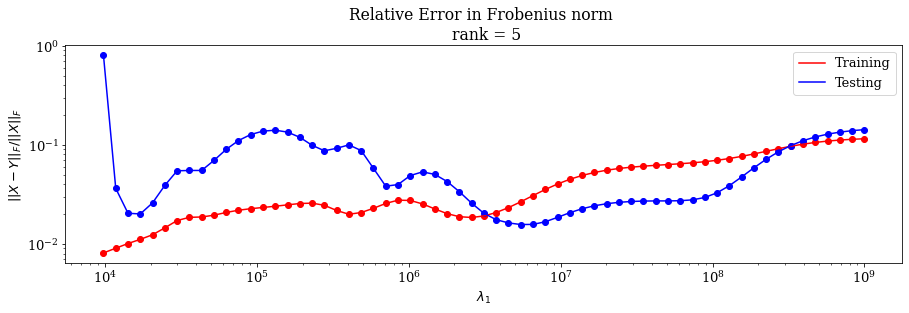

In [71]:
fig, ax = plt.subplots(figsize=(15, 4))

coeff_array = 10**np.linspace(1, 9, 100)

training_error = np.ones((2, len(coeff_array))) * np.inf
testing_error = np.ones((2, len(coeff_array))) * np.inf

for kk, coeff in enumerate(coeff_array):
    
    Vr, _ = roi.pre.pod_basis(X_train, r=rank)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)   # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=coeff)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = convert_from_x_to_v(X_ROM)
        # save
        training_error[0, kk] = coeff
        training_error[1, kk] = roi.post.frobenius_error(V[:, :l], V_ROM[:, :l])[1]
        # save
        testing_error[0, kk] = coeff
        testing_error[1, kk] = roi.post.frobenius_error(V[:, l:], V_ROM[:, l:])[1]
        
ax.plot(training_error[0, :], training_error[1, :],  c="r", label="Training")
ax.scatter(training_error[0, :], training_error[1, :],  c="r")
ax.plot(testing_error[0, :], testing_error[1, :],  c="b", label="Testing")
ax.scatter(testing_error[0, :], testing_error[1, :],  c="b")

_ = plt.xscale("log")
_ = plt.yscale("log")
_ = ax.set_xlabel("$\lambda_{1}$")
_ = ax.set_ylabel("$||X - Y||_{F} / ||X||_{F}$")
_ = ax.set_title("Relative Error in Frobenius norm \n rank = " + str(rank))
_ = plt.legend()

In [72]:
optimal_reg = training_error[0, np.argmin(training_error[1, :])]
print("Optimal Regularization Coefficent = ", optimal_reg)

Optimal Regularization Coefficent =  9770.099572992256


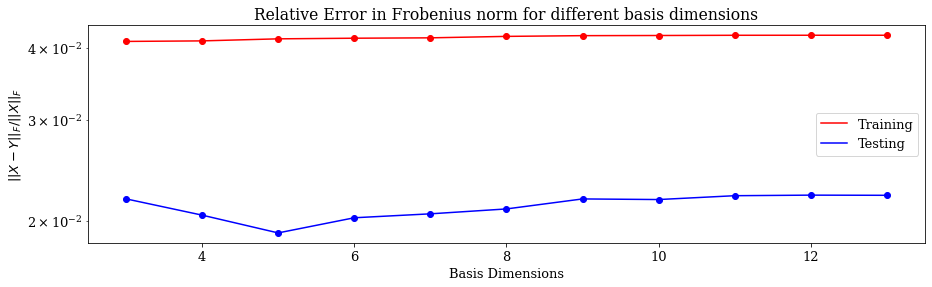

In [73]:
fig, ax = plt.subplots(figsize=(15, 4))

rank_array = np.arange(3, 14)

training_error = np.ones((2, len(coeff_array))) *np.inf
testing_error = np.ones((2, len(coeff_array))) *np.inf

for kk, r_val in enumerate(rank_array):
    Vr, _ = roi.pre.pod_basis(X_train, r=r_val)                       # Construct the reduced basis.
    Xdot = roi.pre.xdot(X_train, (r_train[1] - r_train[0]).value, order=6)   # Calculate the right-hand side matrix.
    model = roi.InferredContinuousROM(modelform="H")              # Define the model structure.
    model.fit(Vr, X_train, Xdot, P=1E7)                          # Construct the ROM with Operator Inference.
    X_ROM = model.predict(X[:, 0], r.value, method="BDF", max_step=(r_train[1] - r_train[0]).value) # Simulate the ROM.
    if np.shape(X_ROM) == np.shape(X):
        V_ROM = convert_from_x_to_v(X_ROM)
        # save
        training_error[0, kk] = r_val
        training_error[1, kk] = roi.post.frobenius_error(V[:, :l], V_ROM[:, :l])[1]
        # save
        testing_error[0, kk] = r_val
        testing_error[1, kk] = roi.post.frobenius_error(V[:, l:], V_ROM[:, l:])[1]
        
    
        
ax.plot(training_error[0, :], training_error[1, :],  c="r", label="Training")
ax.scatter(training_error[0, :], training_error[1, :],  c="r")
ax.plot(testing_error[0, :], testing_error[1, :],  c="b", label="Testing")
ax.scatter(testing_error[0, :], testing_error[1, :],  c="b")

#_ = plt.xscale("log")
_ = plt.yscale("log")
_ = ax.set_xlabel("Basis Dimensions")
_ = ax.set_ylabel("$||X - Y||_{F} / ||X||_{F}$")
_ = ax.set_title("Relative Error in Frobenius norm for different basis dimensions")
_ = plt.legend()

# Sensitivity to Training Data

* **Test 1**: x training snapshots. 

* **Test 2**: x training snapshots. 

* **Test 3**: x training snapshots.

In [117]:
# initialize the training length. 
l1, l2, l3 = int(0.4*len(r)), int(0.55*len(r)), int(0.7*len(r))


X_train1 = X[:, :l1]
X_test1 = X[:, l1:-1]


X_train2 = X[:, :l2]
X_test2 = X[:, l2:-1]


X_train3 = X[:, :l3]
X_test3 = X[:, l3:-1]

In [118]:
r_train1 = r[:l1]
r_test1 = r[l1:-1]

r_train2 = r[:l2]
r_test2 = r[l2:-1]

r_train3 = r[:l3]
r_test3 = r[l3:-1]

In [119]:
# l1 = compute the results for quadradic with 3 modes.
rank=5
Vr, _ = roi.pre.pod_basis(X_train1, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train1, (r_train[1] - r_train[0]).value, order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
model.fit(Vr, X_train1, Xdot, P=1e3)                          # Construct the ROM with Operator Inference.
X_ROM1 = model.predict(X[:, 0], r.value, method="BDF") # Simulate the ROM.
V_ROM1 = convert_from_x_to_v(X_ROM1)

# l2 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train2, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train2, (r_train[1] - r_train[0]).value, order=6)  # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
model.fit(Vr, X_train2, Xdot, P=1e3)                          # Construct the ROM with Operator Inference.
X_ROM2 = model.predict(X[:, 0], r.value, method="BDF") # Simulate the ROM.
V_ROM2 = convert_from_x_to_v(X_ROM2)

# l3 = compute the results for quadradic with 3 modes.
Vr, _ = roi.pre.pod_basis(X_train3, r=rank)                       # Construct the reduced basis.
Xdot = roi.pre.xdot(X_train3, (r_train[1] - r_train[0]).value, order=6) # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="A")              # Define the model structure.
model.fit(Vr, X_train3, Xdot, P=1e3)                          # Construct the ROM with Operator Inference.
X_ROM3 = model.predict(X[:, 0], r.value, method="BDF") # Simulate the ROM.
V_ROM3 = convert_from_x_to_v(X_ROM3)

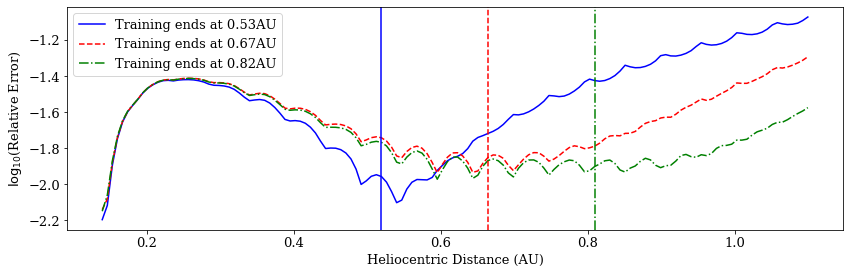

In [125]:
fig, ax = plt.subplots(figsize=(12, 4))
# l1
abs_l2err1, rel_l2err1 = roi.post.lp_error(V, V_ROM1)
_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2err1), "-", c="b", label="Training ends at " + str(round(r[l1].to(u.AU).value, 2)) + "AU")

#l2
abs_l2err2, rel_l2err2 = roi.post.lp_error(V, V_ROM2)
_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2err2), "--", c="r", label="Training ends at " + str(round(r[l2].to(u.AU).value, 2)) + "AU")

#l3
abs_l2err3, rel_l2err3 = roi.post.lp_error(V, V_ROM3)
_ = ax.plot(r.to(u.AU).value, np.log10(rel_l2err3), "-.", c="g", label="Training ends at " + str(round(r[l3].to(u.AU).value, 2)) + "AU")

_ = ax.axvline(r_train1[-1].to(u.AU).value, linestyle="-", c="b")
_ = ax.axvline(r_train2[-1].to(u.AU).value, linestyle="--", c="r")
_ = ax.axvline(r_train3[-1].to(u.AU).value, linestyle="-.", c="g")
#_ = ax.set_title(r"L2-Norm Error")
_ = ax.set_ylabel("$\log_{10}$(Relative Error)")
_ = ax.set_xlabel("Heliocentric Distance (AU)")

plt.legend()
#plt.suptitle(str(model) + "\n" + "rank = " + str(rank))
plt.tight_layout()

plt.savefig("MHD/figs/CR2210/A/sensitivity_to_number_of_training_snapshots.png", dpi=300)